# Сегментация клиентов для создания кастомизированных предложений

С помощью **RFM анализа** и данных по продажам супермаркета, все клиенты будут поделены на группы.

### Что это?

RFM анализ - это анализ клиентской базы на основе трех параметров:

* **R**ecency (**"НеДавность"**) - время с последеней транзакции.
* **F**requency (**Частота**) - как частота совершаются транзакции.
* **M**onetary value (**Монетарная ценность**) - общая сумма покупок.



---


### Какая цель?
Сегментация клиентов. Так мы поделим клиентов на группы, с каждой из которых нужно будет выстравивать свои стратегии коммункаций, рекламы и предложений.



---

###  Что за данные и Откуда они?

Транзакции клиентов за послдение 12 месяцев* в одном из британских онлайн-маркетов из открытого источника.

Источник: [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/online+retail)


*В оригинальном датасете предсталены данные больше, чем за 12 месяцев. Но для этого анализа взяты данные только за 12 месяцев для сокращения объемов.

---

### Что в колонках?

* **InvoiceNo**: номе счета-фактуры.
* **StockCode**: код продукта.
* **Description**: описание продукта.
* **Quantity**: количество.
* **InvoiceDate**: дата транзакции (счета-фактуры).
* **UnitPrice**: цена за 1 единицу.
* **CustomerID**: идентификационный номер клиента.
* **Country**: страна.


---

### Инструменты:

Для этoго проекты я использовала Numpy и Pandas для манипуляции с данными, Matplotlib и Seaborn для визуализации, sklearn.cluster.KMeans для кластеризации и StandardScaler для подготовки данных к моделированию.



---
### Основные шаги:

1. Обзор и Проверка данных на "чистоту".
2. Создание RFM матрицы
3. Подготовка данных для машинного обучения.
4. Кластеризация с помощью KMeans

    *   Модель и получение кластеров
    *   Интерпрретация результатов и их визуализация
5. Кластеризация "вручную"
    * Деление на три кластера
    * Деление на 27 кластеров
    * Интерпретация результатов



---
### Выводы:

* Клиентов можно разделить на группы, которые явно прослеживаются на основе того, как давно, как часто и на какие суммы они делали покупки.

* Для каждой группы можно подобрать и аргумментировать свою мааркетинговую стратегию.

## Импорт

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('online12M.csv')
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [ ]:
df.shape

(68176, 9)

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

## Подробнее посмотреть на данные

In [ ]:
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,68176.000000,68176.000000
mean,11.556119,3.069209
std,41.133000,32.513232
min,1.000000,0.001000
25%,2.000000,1.250000
50%,4.000000,1.850000
75%,12.000000,3.750000
max,4300.000000,8142.750000


Выглядит так, как будто в данных много **выбросов**.

In [ ]:
df[df['UnitPrice']> 2000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
5323,551697,POST,POSTAGE,1,2011-05-03,8142.75,16029,United Kingdom


In [ ]:
df[df['Quantity']> 2000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
24538,574294,21915,RED HARMONICA IN BOX,2100,2011-11-03,1.06,16333,United Kingdom
45286,543057,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2592,2011-02-03,0.21,16333,United Kingdom
47691,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27,0.72,13135,United Kingdom


Экстримальнеы значения для Количества (Quantity) выглядят правдоподобно. А вот для цены (UnitPrice) - что-то странное.

In [ ]:
df = df.drop(index=[5323])

In [ ]:
#Посмотреть данные по чекам (минимальный и максимальный размер, среднее значение)

(df['UnitPrice']*df['Quantity']).describe()

count    68175.000000
mean        19.688990
std         70.366729
min          0.001000
25%          4.160000
50%         10.200000
75%         17.700000
max       4921.500000
dtype: float64

In [ ]:
(df['UnitPrice']*df['Quantity']).quantile(0.99)

179.0

Можно увидеть, что все равно распределение размеров чеков очень скошено.
75% всех значений не превышают 17.7 у.е. 99% - 179 у.е. При этом максимум - 4921.5.

## Подготовка данных

In [ ]:
#Проверка пропущенных значений

df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
#Проверка дубликатов

df[df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'InvoiceDate'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
17376,538312,22738,RIBBON REEL SNOWY VILLAGE,5,2010-12-10,1.65,16727,United Kingdom
26819,538312,22738,RIBBON REEL SNOWY VILLAGE,5,2010-12-10,1.65,16727,United Kingdom
37207,538419,21380,WOODEN HAPPY BIRTHDAY GARLAND,1,2010-12-12,2.95,16367,United Kingdom
61950,538419,21380,WOODEN HAPPY BIRTHDAY GARLAND,1,2010-12-12,2.95,16367,United Kingdom
9972,538510,22812,PACK 3 BOXES CHRISTMAS PANNETONE,1,2010-12-12,1.95,18004,United Kingdom
...,...,...,...,...,...,...,...,...
67136,581134,21592,RETROSPOT CIGAR BOX MATCHES,1,2011-12-07,0.39,16368,United Kingdom
2651,581147,23332,IVORY WICKER HEART LARGE,5,2011-12-07,1.65,16426,United Kingdom
65286,581147,23332,IVORY WICKER HEART LARGE,5,2011-12-07,1.65,16426,United Kingdom
34620,581414,22326,ROUND SNACK BOXES SET OF4 WOODLAND,1,2011-12-08,2.95,14730,United Kingdom


In [ ]:
df = df.drop_duplicates()
df[df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'InvoiceDate'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [ ]:
df.shape

(67951, 8)

In [ ]:
#добаление новой колонки с суммой

df['TotalSum'] = df['UnitPrice']*df['Quantity']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67951 entries, 0 to 68175
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    67951 non-null  int64  
 1   StockCode    67951 non-null  object 
 2   Description  67951 non-null  object 
 3   Quantity     67951 non-null  int64  
 4   InvoiceDate  67951 non-null  object 
 5   UnitPrice    67951 non-null  float64
 6   CustomerID   67951 non-null  int64  
 7   Country      67951 non-null  object 
 8   TotalSum     67951 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 5.2+ MB


In [ ]:
#изменить тип данных колонки с датами

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
#определить день гипотетиеского анализа (следующий после последнего дня в датасете)

check_day = max(df['InvoiceDate']) + datetime.timedelta(days=1)

## RFM матрица

* Recency (давность) - время с последеней транзакции
* Frequency (частота) - как частота совершаются транзакции
* Monetary value (Монетарная ценность) - общая сумма покупок)

In [ ]:
# сгруппированный датасет

gr_df = df.groupby('CustomerID').agg({
    "InvoiceDate": lambda x: (check_day - max(x)).days,
    "InvoiceNo": 'count',
    "TotalSum": 'sum'
})

gr_df.rename(columns={ "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalSum": "MonetaryValue"}, inplace=True)

gr_df.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,875,6987.17
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


## Подготовка к KMeans

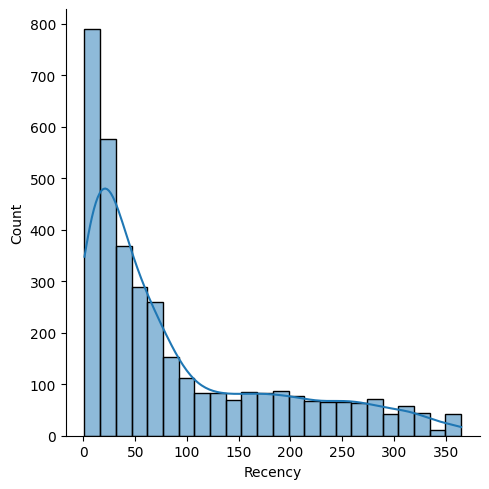

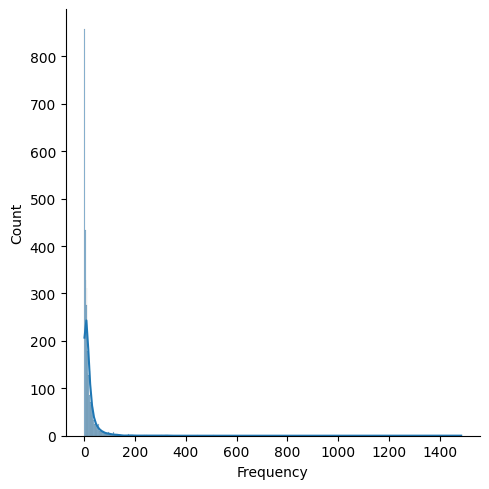

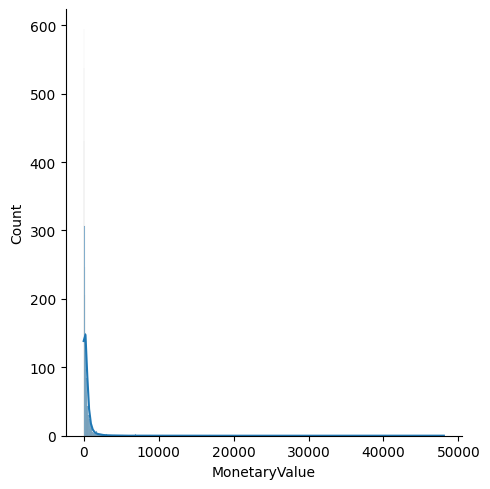

In [ ]:
# проверка на нормальность распределения

for i in ['Recency', 'Frequency', 'MonetaryValue' ]:
   sns.displot(gr_df[i], kde=True)


По графикам видно, что рапсределние всех перемменных отклоняются от нормального(длинный хвост вместо фоормы колокола).

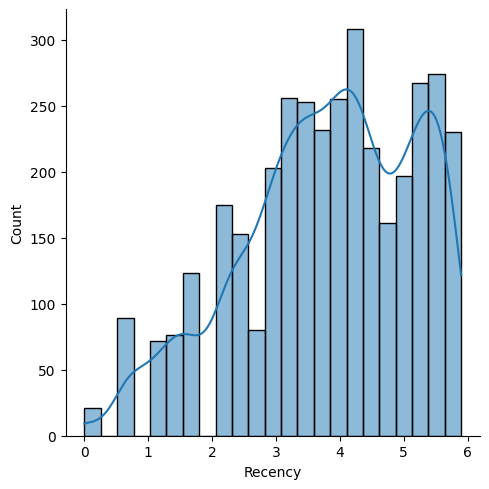

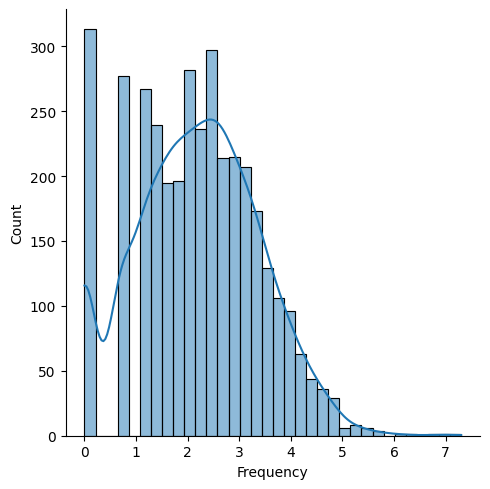

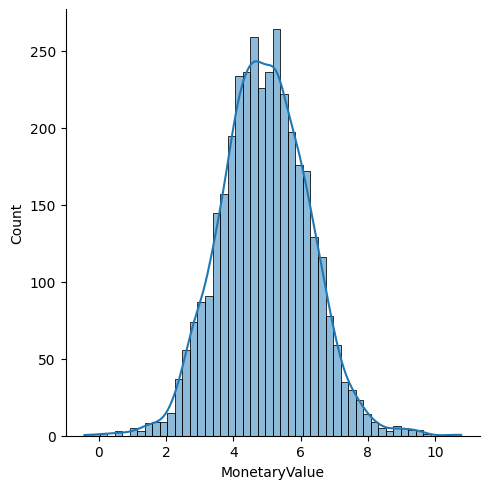

In [ ]:
#log трансформация

df_log = np.log(gr_df)

for i in ['Recency', 'Frequency', 'MonetaryValue' ]:
   sns.displot(df_log[i], kde=True)


Распределение приобрело более "нормальный" вид.

In [ ]:
# Стандартизация данных (среднее=0, станд. отклонение=1)

scaler = StandardScaler()
scaler.fit(df_log)
df_scaled = scaler.transform(df_log)


Стандартизация нужна, потому что KMeans алгоритм очень чувствителен к разницам в шкалах колонок-переменных.

## Моделирование

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

<Axes: >

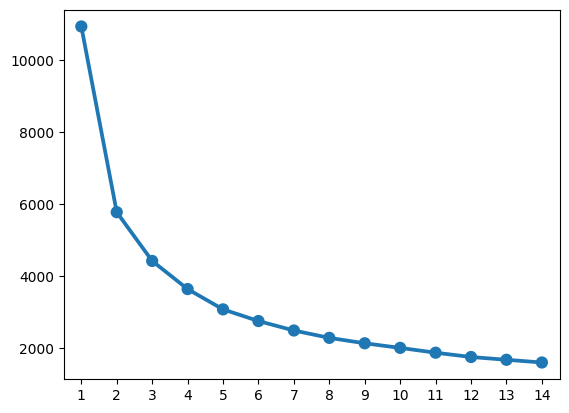

In [ ]:
#определяем оптимальное k

inertias = []

for k in range(1,15):
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(df_scaled)
  inertias.append(kmeans.inertia_)


sns.pointplot(x=list(range(1,15)), y=inertias)

In [ ]:
# 3 группы

kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_scaled)
gr_df['three_Clusters'] = kmeans.labels_

gr_df.groupby('three_Clusters').agg({"Recency": 'mean',
                                'Frequency':'mean',
                                'MonetaryValue':['mean', 'count']})

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency  Frequency MonetaryValue      
                      mean       mean          mean count
three_Clusters                                           
0               166.296552   3.042241     52.981767  1160
1                16.469813  49.704720   1035.553447   911
2                77.321247  12.176209    214.058658  1572

In [ ]:
# 4 группы

kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(df_scaled)
gr_df['four_Clusters'] = kmeans.labels_

gr_df.groupby('four_Clusters').agg({"Recency": 'mean',
                                'Frequency':'mean',
                                'MonetaryValue':['mean', 'count']})

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency  Frequency MonetaryValue      
                     mean       mean          mean count
four_Clusters                                           
0              129.442308  11.752747    231.362015  1092
1               19.287582  10.471895    146.507282   765
2              164.492147   2.617801     44.189497   955
3               19.567990  53.677497   1124.454741   831

Оптимальное деление здесь - на 3 группы.

* (1) кто покупал недавно, покупает часто, в сумме потратил много. "Лучшие" клиенты. Те, для кого нужны программы лояльности и особенные предложения.

* (2) кто покупал давно, не так часто и не так много потрратил, как первая группа. "Средние" клиенты. Те, для кого нужно создавать особенные предложения, чтобы расшевелить их активность.

* (0) кто покупал очень давно, очень редко, на небольшие суммы"(почти) Потерянные" клиенты.

## Визуализация кластеризации

In [ ]:
gr_df.head()

,Recency,Frequency,MonetaryValue,three_Clusters,four_Clusters
CustomerID,,,,,
12747,3,25,948.70,1,3
12748,1,875,6987.17,1,3
12749,4,37,813.45,1,3
12820,4,17,268.02,1,3
12822,71,9,146.15,2,0


Text(0, 0.5, 'Количество')

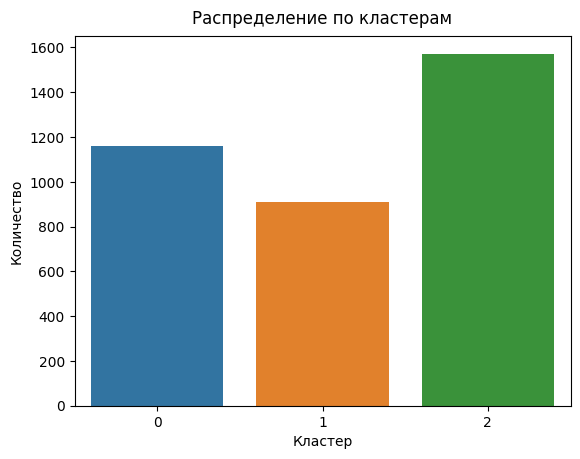

In [ ]:
sns.countplot(x=gr_df["three_Clusters"])
plt.title('Распределение по кластерам', va='bottom')
plt.xlabel('Кластер')
plt.ylabel('Количество')

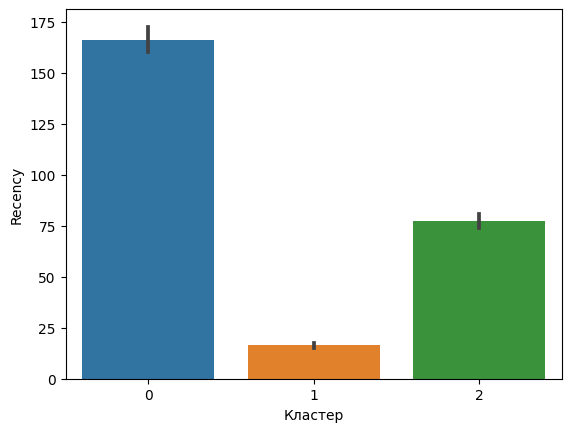

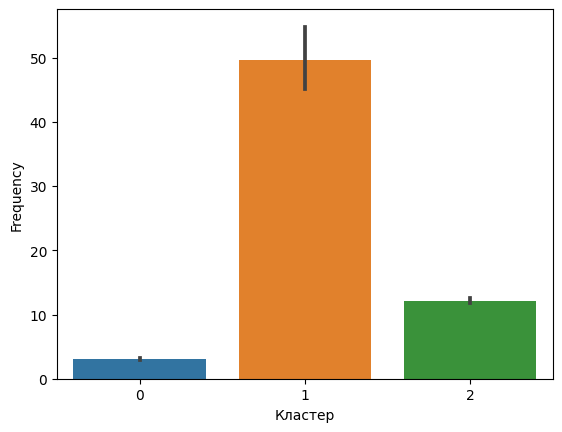

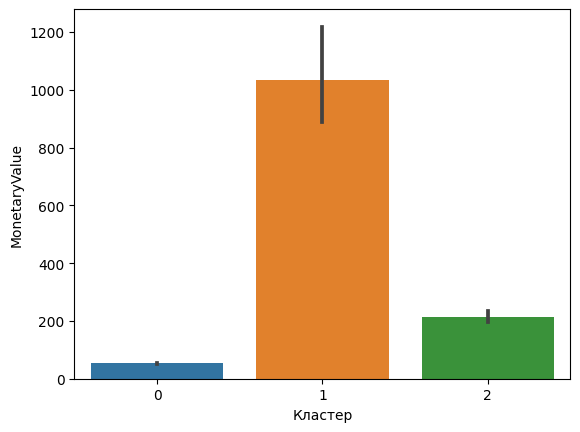

In [ ]:
for col in ['Recency', 'Frequency', 'MonetaryValue']:
   sns.barplot(x=gr_df['three_Clusters'], y=gr_df[col])
   plt.xlabel('Кластер')
   plt.show()

### Выводы:

* Мы имеем три группы клиентов по степени объема покупок, недавности последней покупки и суммарных трат. (1) Клиенты, которые лидирует по всем трем показателям. (2) Клиенты, которые отстают по всем показателям и (3) "Среднячки".

* Самая распространенная группа - "Среднячки". Именно на них следует сделать упор при подготовке следующей рекламной или коммуникационной компании, замотивировать их совершать покупки снова, увеличить их объем и т.п.

## Кластерный анализ вручную

In [ ]:
#Подготовкаа данных

rfm = gr_df.drop(['three_Clusters', 'four_Clusters'], axis=1)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,875,6987.17
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [ ]:
# По каждой колонке разбить на три группы, три квантиля

rfm['R'] = pd.qcut(rfm['Recency'], 3, labels = list(range(3,0,-1))).astype('int')
rfm['F'] = pd.qcut(rfm['Frequency'], 3, labels = list(range(1,4))).astype('int')
rfm['M'] = pd.qcut(rfm['MonetaryValue'], 3, labels = list(range(1,4))).astype('int')

def join_cols(rfm):
  return str(rfm['R']) + str(rfm['F']) + str(rfm['M'])

rfm['RFM_cluster'] = rfm.apply(join_cols, axis=1)
rfm['RFM_score'] = rfm['R'] + rfm['F'] + rfm['M']

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_cluster,RFM_score
CustomerID,,,,,,,,
12747,3,25,948.70,3,3,3,333,9
12748,1,875,6987.17,3,3,3,333,9
12749,4,37,813.45,3,3,3,333,9
12820,4,17,268.02,3,3,3,333,9
12822,71,9,146.15,2,2,2,222,6


* 1, 2 , 3 в колонках R, F, M - это как бы оценка параметра, где 3 - самый лучший показатель.

* RFM_score - это сумма оценок по трем показателей.

* RFM_cluster - название кластера, по которому легко понять знаечния отдельных параметров (RFM).




NB Из-за того, что здесь используется обратый порядок для составления рейтинга по колонке "Недавность", 3 - это лучший показатель (самый короткий срок), 1 - самый худший.

In [ ]:
rfm.groupby('RFM_cluster').agg({"Recency": 'mean',
                                'Frequency':'mean',
                                'MonetaryValue':['mean', 'count']})

Recency  Frequency MonetaryValue      
                   mean       mean          mean count
RFM_cluster                                           
111          224.532819   2.453668     35.486351   518
112          211.354167   3.277778    129.385625   144
113          198.512195   2.634146    806.982195    41
121          214.752475   8.485149     50.630693   101
122          188.824268   9.150628    145.308661   239
123          164.575000  10.525000    505.488500    40
131          180.818182  18.727273     58.959091    11
132          187.297872  24.638298    152.426596    47
133          150.926471  27.205882    470.085000    68
211           56.563910   2.609023     39.173947   266
212           54.468085   3.787234    117.790000    94
213           64.464286   3.321429    492.256786    28
221           52.532468   9.207792     47.035844    77
222           55.389961   9.424710    148.600622   259
223           54.096154  11.221154    490.207019   104
231           48.357143  18.428571     64.720000    14
232           51.546512  24.616279    154.043023    86
233           50.387597  35.391473    666.109806   258
311           15.376812   2.746377     41.776667   138
312           13.222222   3.800000    118.187333    45
313           14.882353   3.235294    817.968235    17
321           15.931507   9.616438     51.459452    73
322           14.696133  10.022099    151.641105   181
323           13.623656  11.397849    584.744086    93
331           13.764706  20.235294     62.714706    17
332           13.848739  27.075630    156.341429   119
333           10.757522  61.430088   1286.348354   565

In [ ]:
rfm['RFM_cluster'].nunique()

27

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, '333'),
  Text(1, 0, '111'),
  Text(2, 0, '211'),
  Text(3, 0, '222'),
  Text(4, 0, '233'),
  Text(5, 0, '122'),
  Text(6, 0, '322'),
  Text(7, 0, '112'),
  Text(8, 0, '311'),
  Text(9, 0, '332'),
  Text(10, 0, '223'),
  Text(11, 0, '121'),
  Text(12, 0, '212'),
  Text(13, 0, '323'),
  Text(14, 0, '232'),
  Text(15, 0, '221'),
  Text(16, 0, '321'),
  Text(17, 0, '133'),
  Text(18, 0, '132'),
  Text(19, 0, '312'),
  Text(20, 0, '113'),
  Text(21, 0, '123'),
  Text(22, 0, '213'),
  Text(23, 0, '313'),
  Text(24, 0, '331'),
  Text(25, 0, '231'),
  Text(26, 0, '131')])

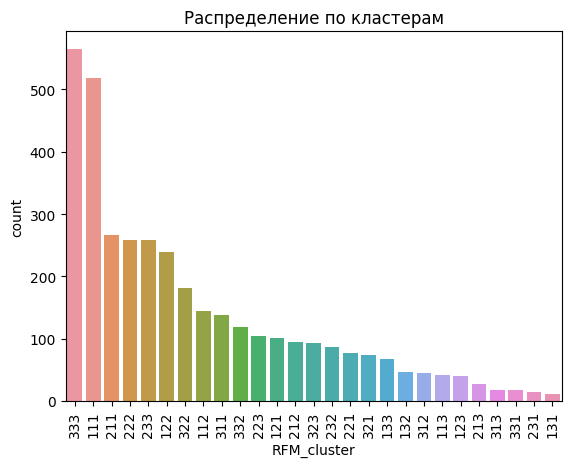

In [ ]:
sns.countplot(x=rfm['RFM_cluster'],
              orient='v',
              order = rfm['RFM_cluster'].value_counts().index)
plt.title('Распределение по кластерам')
plt.xticks(rotation='vertical')

Получается 27 кластеров (все 27 присутствуют), где 1 - самые худшие значения, 3 - самые лучшие.


---
На основе этих данных можно строить разные стратегии поведения и коммуникаций с разными группами клиентов. Кого удерживать, у кого стараться повысить активность, кого пытаться вернуть в зависмости от рейтинга.

Основные группы, на которые стоит обратить внимание:

* **333** -  основные клиенты, лучшие покупатели. Не чувствиетльны к цене, скидки их не мотивируют. Для них создаются карты лояльности, особые предложения, мероприятия, которые бы подчеркивали их особый статус, чтобы их удержать в этом статусе.

* **331** и **332** - частые клиенты, которые тратят не так много. Для них актуальны особые программмы скидок и бонусы.

* **133** (те, кто покупал часто и на большие суммы), 132 и 131 (часто, но не на большие суммы). Но эти группы давно уже ничего не покупали. Почему? Можно исследовать это, запросить обратную связь. Можно попытаться вернуть этих клиентов.

* **233**, **232**, **231**, **222**, **212** - это те, кто имел историю покупок, но тоже перестал покупать (хотя не так давно, если сравнивать с группой выше). Здесь фокус должен быть на напоминании о себе и возвращении этих клиентов. Рекламные предложения, рассылки, бонусы, акции.

* **31х**  - те, кто только нача что-то покупать, новички. Их нужно постараться вовлечь и удержать. Специальные акции, дополнительные скидки на дополнительные покупки, напоминания о себе в рассылках, социальных сетях, таргетированной рекламе.


Саммари:



1.   На основе датасета по транзакциямм клиентов была создана RFM матрица.
2.   С помощью алгоритма KMeans
все клиенты были поделены на три сегмента.
3. С помощью определения рейтинга каждого клиента по показателями Недавности, Частоты и Монетарной ценности была составлена другая кластеризация. С возможностью бОльшей детализации.
4. Для каждой группы даны краткие рекомендации по взаимодействию с клиентами с точки зрения маркетинга, рекламы и коммуникаций.

